# Part A: Linear Support Vector Machine (SVM)

The dataset used will be the Iris dataset for binary classification, with features of petal length and petal width, and to determine if a sample is Iris Virginica or not. 

In [1]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report


### 1. Implement a Linear_SVC model class for performing binary classification. The model implements the batch Gradient Descent algorithm. 
### 8. EXTRA CREDIT: Implement early stopping in the "fit" method of the Linear_SVC model, using the parameters early_stopping and validation_fraction. This question will also be mentioned when testing it. 

In [2]:
class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=500, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.w = np.random.rand(2,1)
        self.b = 0
        #self.w = np.reshape(np.array([[1.60381071, 3.05536121]]),(2,1))
        #self.b = -1.13503736      
        self.epochs = max_iter
        self.lr_sc = learning_rate
        self.learning_rate = learning_rate_init
        self.tol = tol 
        self.t_0 = t_0
        self.t_1 = t_1
        self.loss = 1e5
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
    
    def fit(self,X,y):
        ##ADd early_stopping like Assignment 3
        epch_counter = 0
        
        val_loss = []
        self.validation_score=1e5
        
        if self.early_stopping:
            X, X_valid, y, y_valid = split_trainTest(X, y, self.validation_fraction)
        
        # y was re-assigned into 1 and -1.
        t = (2 * y - 1)[:,None]
        
        
        while epch_counter < self.epochs:
            loss = self.loss
            epch_counter += 1
            validation_score = self.validation_score
            #print(f'Epoch: {epch_counter}')
            #pdb.set_trace()
            w = self.w
            b = self.b
            if(self.lr_sc == "adaptive"):
                self.learning_rate = self.t_0 /(epch_counter + self.t_1)    
        
            idx_sv = ((t * ((X @ w) + b)) < 1).ravel()
            X_sv = X[idx_sv]
            t_sv = t[idx_sv]
            
            self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- (t_sv * (X_sv @ w))) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- X_sv@w) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*np.sum((np.maximum(0,1-t*(X@w+b)))))).item()
            # print(self.loss)
            dw = w - (self.C * np.sum(t_sv * X_sv))
            db = -self.C * np.sum(t_sv)
            
            self.w = w - self.learning_rate * dw
            self.b = b - self.learning_rate * db
            self.support_vectors_ = X_sv
            ## Assing intercept,Coef and Support vec
            
            if self.early_stopping:
                t_val = (2 * y_valid - 1)[:,None]
                self.validation_score = ((0.5 * (self.w.T @ self.w))+ (self.C * (np.sum(1- (X_valid @ self.w)) - b * np.sum(t_val)))).item()
                val_loss.append(self.validation_score)
                # print("self.validation_score", self.validation_score)
                # print("self.loss", self.loss)
                if (self.validation_score > validation_score):
                    print(f'\nEarly Stopping at : {epch_counter}\n')
                    plt.plot(range(epch_counter), val_loss, "--", color='darkorange', lw = 2)
                    plt.xlabel("epoch")
                    plt.ylabel("Loss : J(w)")
                    break
            
            if (self.tol != None) and (np.abs(self.loss - loss) < self.tol):         
                break
                    
        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
        
    def predict(self,X):
        return ((X@self.coef_[0] + self.intercept_[0]) >= 1).astype(np.int)
        
        

## Binary Classification using Linear_SVC Classifier

### 2. Read the Iris data using sklearn.datasets.load_iris. Create data matrix X using petal length and petal width as features, and recode the binary "target" such that Iris-Virginica samples are 1, and the other samples are 0.

In [3]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  
y = (iris["target"] == 2).astype(np.int)[:,None]

In [4]:
Z = np.hstack([X,y])
np.random.shuffle(Z)
X= Z[:,0:2]
y = Z[:,2]

### 3. Partition the data into train and test set, using custom partition function. (80% train, 20% test). 
We also choose to standardize the data.

In [5]:
# Standarize the data
X = (X - np.mean(X))/np.std(X)

def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]

X_train, X_test, y_train, y_test = split_trainTest(X,y,t=0.2)

The below sFold function and s_partition, are a replacement for sklearn kFold function, and helps to find optimal values for hyperparameters.

In [6]:
def sFold(folds,data,labels,model,error_fuction,**model_args):
    if(labels.shape == (labels.shape[0],)):
        labels = np.expand_dims(labels,axis=1)
    dataset = np.concatenate([data,labels],axis=1)
    s_part = s_partition(dataset,folds)
    pred_y = []
    true_y = []
    err_func = []
    for idx,val in enumerate(s_part):
        test_y = val[:,-1]
        #test_y = np.expand_dims(test_y, axis=1)
        test = val[:,:-1]
        train = np.concatenate(np.delete(s_part,idx,0))
        label = train[:,-1]
        train = train[:,:-1]        
        #model.fit(train,label,**model_args) 
        model.fit(train,label)  
        pred = model.predict(test)
        
        pred_y.append(pred)
        true_y.append(test_y[:,None])
        err_func.append(error_fuction(pred,test_y[:,None]))
    avg_error = np.array(err_func).mean()
    result = {'Expected labels':true_y, 'Predicted labels': pred_y,'Average error':avg_error }
    return result

def s_partition(x,s):
    return np.array_split(x,s)

def accuracy(x,y):
    x,y = np.array(x),np.array(y)
    pred = (x == y).astype(np.int)
    return pred.mean()

### 4. Use the sFold function to find optimal values for the hyperparameters: C, learning_rate, learning_rate_init, max_iter, and tol. 

In [7]:
def findOptimalSVM():
    validation_accuracy = np.empty((4,6,2,5,5))
    learning_rate_init = [0.1 , 0.01, 0.001, 0.0001]
    C = [0.01,0.5 , 1 , 10, 50, 100]
    learning_rate= ['constant', 'adaptive']
    max_iter = [10, 35, 50, 100, 500]
    tol = [None, 0.1, 1, 0.01, 5]
    maxScore = 0
    for i,lri in enumerate(learning_rate_init):
        for j,c in enumerate(C):
            for k,lr in enumerate(learning_rate):
                for l,mi in enumerate(max_iter):
                    for m,tl in enumerate(tol):
                        model_args = {'learning_rate' : lr,'C':c,'learning_rate_init' : lri,'max_iter' : mi,'tol' : tl}
                        lrSvM = Linear_SVC(**model_args) 
                        result = sFold(5,X,y,lrSvM, error_fuction = accuracy,**model_args)
                        validation_accuracy[i,j,k,l,m] = result['Average error']
                        if validation_accuracy[i,j,k,l,m] > maxScore:
                            maxScore = validation_accuracy[i,j,k,l,m]
                            index = [i,j,k,l,m]

    print(index)
    a,b,c,d,e= index
    print('optimal learning_rate_init: ',learning_rate_init[a])
    print('optimal C: ',C[b])
    print('optimal learning_rate: ',learning_rate[c])
    print('optimal max_iter',max_iter[d])
    print('optimal tol',tol[e])
    print('optimal value',validation_accuracy[a,b,c,d,e])
    opt_dic = {'learning_rate' : learning_rate[c],'C':C[b],'learning_rate_init' : learning_rate_init[a],'max_iter' : max_iter[d],'tol' : tol[e]}   
    return opt_dic

In [8]:
opt_mod = findOptimalSVM()

[0, 1, 0, 2, 0]
optimal learning_rate_init:  0.1
optimal C:  0.5
optimal learning_rate:  constant
optimal max_iter 50
optimal tol None
optimal value 0.9666666666666668


### 5. Train the model using optimal values for the hyperparameters, and evaluate on the test data. Report the test accuracy, and the Test Confusion Matrix

In [9]:
model = Linear_SVC(**opt_mod)

In [10]:
opt_mod

{'learning_rate': 'constant',
 'C': 0.5,
 'learning_rate_init': 0.1,
 'max_iter': 50,
 'tol': None}

In [11]:
model.fit(X_train,y_train)

In [12]:
pred = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(pred, y_train))


y_test_predicted = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


Train Accuracy:  0.9583333333333334
Test Accuracy:  1.0

Test Confusion Matrix:
[[21  0]
 [ 0  9]]


### 7. Plot the decision boundary and show the support vectors using the decision_boundary_support_vectors function.

In [13]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)    
    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

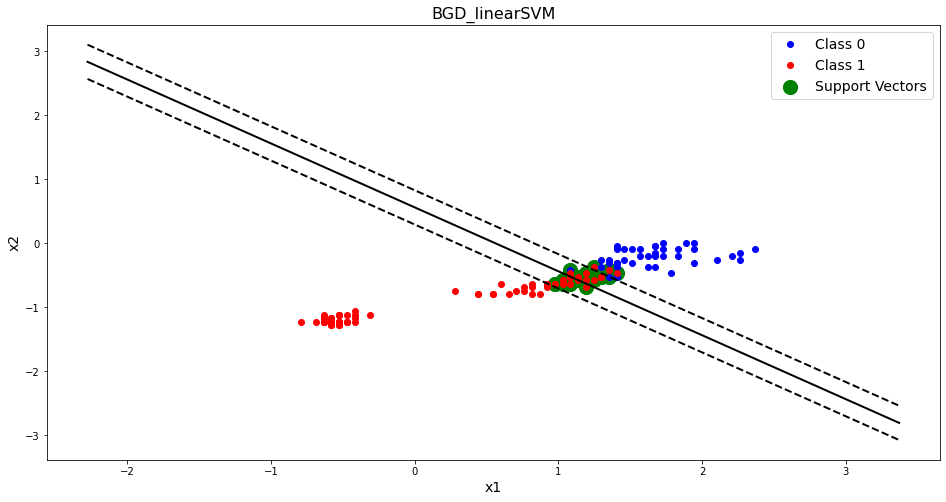

In [14]:
plt.figure(figsize=(16,8))
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="Class 0")
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "ro", label="Class 1")

decision_boundary_support_vectors(model, X_train)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()

### 6. Plot the learning Curve

In [15]:
def mse(Y_true, Y_pred):
    E = np.array(Y_true).reshape(-1,1) - np.array(Y_pred).reshape(-1,1)
    mse = 1/np.array(Y_true).shape[0] * (E.T.dot(E))
    return mse[(0,0)]


def kfold_error(model, X, Y, k_fold, learning_rate = 0.01, epochs = 1000, 
                tol = None, regularizer = None, lambd = 0.0, **kwargs):
    if(Y.shape == (Y.shape[0],)):
        Y = np.expand_dims(Y,axis=1)
    dataset = np.concatenate([X,Y],axis=1)

    k_part = s_partition(dataset, k_fold)   # using the function_1 k_partition
    
    error_training = []
    error_validation = []

    for idx,val in enumerate(k_part):
        validation_Y = val[:,-1]
        validation_X = val[:,:-1]
        train = np.concatenate(np.delete(k_part,idx,0))
        train_Y = train[:,-1]
        train_X = train[:,:-1]          
    
        # using our modeling function
        model.fit(train_X,train_Y)
        pr_train_Y = model.predict(train_X)
        pr_validation_Y = model.predict(validation_X)
        mse_train_Y = mse(train_Y, pr_train_Y)
        mse_validation_Y = mse(validation_Y, pr_validation_Y)

        error_training.append(mse_train_Y)
        error_validation.append(mse_validation_Y)

    # return the average mse for the training and the validation fold.
    return np.array(error_training).mean(), np.array(error_validation).mean()

def learning_curve(model, X, Y, cv, train_size = 1, learning_rate = 0.01, 
                   epochs = 1000, tol = None, regularizer = None, lambd = 0.0, **kwargs):
    
    
    if type(train_size) == int and train_size > 1: 
        train_size_abs = train_size
    elif train_size > 0 and train_size <= 1:
        train_size_abs = int(train_size * X.shape[0])
    else:
        print(f'unaceptable train_size of {train_size}')
    
    # print("train_size:", train_size_abs)
    
    if X.shape[0] % train_size_abs != 0:
        t = X.shape[0] // train_size_abs + 1
    else:
        t = X.shape[0] // train_size_abs
    
    # print("iteration:", t)
    
    t0 = 1
    num_samples_list = []
    rmse_training_list = []
    rmse_validation_list = []

    while t0 <= t:
        i = t0 * train_size_abs
        if i >= X.shape[0]: i = X.shape[0]
        index = np.arange(i)
        X_split = (X[index])
        Y_split = (Y[index])
        
        # using the function_2 to calculate the mse, and then rmse using k-fold based on varying training samples.
        rmse_tr, rmse_va = np.sqrt(kfold_error(model, X_split, Y_split, cv, learning_rate = learning_rate, 
                                               epochs = epochs, tol = tol))
        num_samples_list.append(i)
        rmse_training_list.append(rmse_tr)
        rmse_validation_list.append(rmse_va)
        t0 += 1

    result = {'num_samples':pd.Series(num_samples_list), 
              'train_scores':pd.Series(rmse_training_list), 'val_score':pd.Series(rmse_validation_list)}
    learning_curve_elements = pd.DataFrame(result)
    
    return np.array(learning_curve_elements["train_scores"]), \
            np.array(learning_curve_elements["val_score"]), np.array(learning_curve_elements["num_samples"]), \
            learning_curve_elements

In [16]:
cv = 5
train_size = 15
train_scores, val_scores, train_sizes,_ = learning_curve(Linear_SVC(), X_train, y_train, cv, 
                                                         train_size = train_size, learning_rate = 0.01, 
                                                         epochs = 1000, tol = 1e-5)

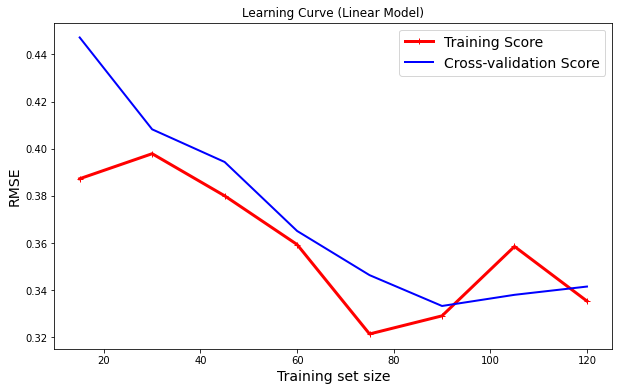

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_scores, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("RMSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

### 8. EXTRA CREDIT: Implement early_stopping, testing portion. This repeats steps 5 and 7 using the early_stopping= True, with a validation fraction which produces an early stopping curve.


Early Stopping at : 6



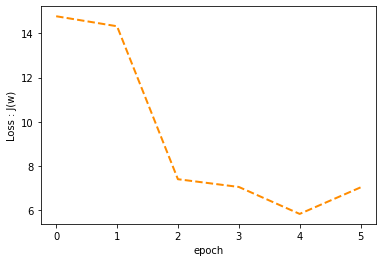

In [18]:
X, y = X_train,y_train
model_early = Linear_SVC(**opt_mod, early_stopping = True, validation_fraction=0.2)
model_early.fit(X,y)

In [19]:
print(model_early.coef_,model_early.intercept_)
support_vectors = model_early.support_vectors_
support_vectors

[[[2.42043306]
  [2.65239478]]] [-1.1]


array([[ 0.92365942, -0.63246702],
       [ 1.24561662, -0.57880749],
       [ 1.08463802, -0.52514796],
       [ 1.19195709, -0.57880749],
       [ 1.40659522, -0.47148843],
       [ 1.24561662, -0.36416936],
       [ 1.35293568, -0.52514796],
       [ 1.08463802, -0.52514796],
       [ 0.97731895, -0.63246702],
       [ 0.81634036, -0.68612656],
       [ 0.97731895, -0.63246702],
       [ 0.81634036, -0.63246702],
       [ 1.08463802, -0.52514796],
       [ 0.92365942, -0.63246702],
       [ 1.13829755, -0.57880749],
       [ 1.40659522, -0.52514796],
       [ 1.03097849, -0.57880749],
       [ 0.92365942, -0.68612656],
       [ 1.29927615, -0.52514796],
       [ 1.24561662, -0.36416936],
       [ 1.08463802, -0.41782889],
       [ 1.19195709, -0.47148843],
       [ 1.29927615, -0.52514796]])

In [20]:
pred = model_early.predict(X)
print("Train Accuracy: ", accuracy_score(pred, y))


y_test_predicted = model_early.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

Train Accuracy:  0.95
Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[21  0]
 [ 1  8]]


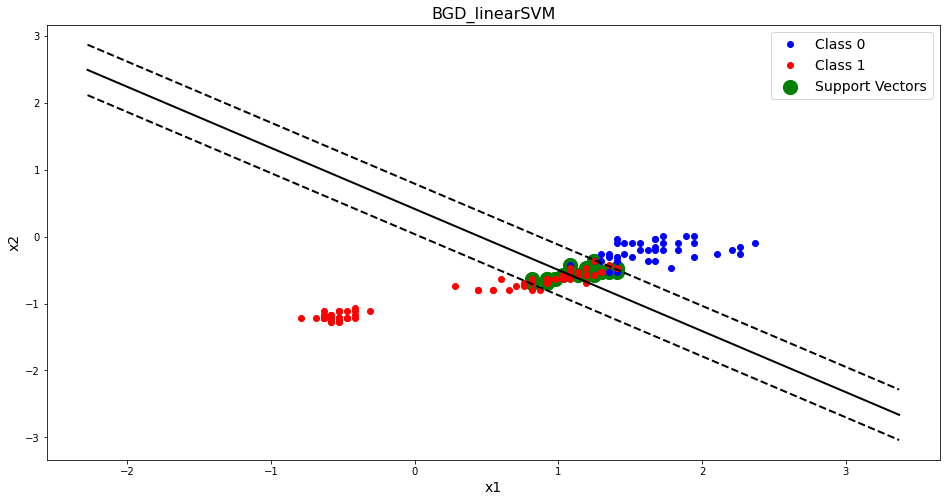

In [21]:
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_support_vectors(model_early, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()